## POOL BPT_WETH
### Comparison simulation - volatility mitigator disabled/enabled

*VM parameters (custom):* 
- WINDOW_SIZE = 24h
- PERIOD_SIZE = 1h
- PRICE_TOLLERANCE_TRESHOLD = 98

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.io as pio

In [2]:
# set rendering mode 'notebook' for interactive view, 'svg' for export
pio.renderers.default = "svg"

In [3]:
pd.set_option('max_rows', 1000)
pd.set_option('max_columns', 1000)

sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [4]:
EXPERIMENT_ID = 71

X_NAME = 'BPT'
Y_NAME = 'WETH'

WINDOW_SIZE = 24 * 60 * 60

In [5]:
BASE_DIR = fr'..\..\..\data\real_transactions\experiment_{EXPERIMENT_ID}'

In [6]:
os.listdir(BASE_DIR)

['0', '1', 'config.txt']

In [7]:
def read_simulation(sim_id: int):
    pool_state_before_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_before_transaction_normalized.csv'
    pool_state_after_transactions_path = fr'{BASE_DIR}\\{sim_id}\pool_after_transaction_normalized.csv'
    swap_transactions_path = fr'{BASE_DIR}\\{sim_id}\swaps_normalized.csv'
    mint_transactions_path = fr'{BASE_DIR}\\{sim_id}\mints_normalized.csv'
    burn_transactions_path = fr'{BASE_DIR}\\{sim_id}\burns_normalized.csv'
    
    # read swaps
    pool0_df = pd.read_csv(pool_state_before_transactions_path)
    pool1_df = pd.read_csv(pool_state_after_transactions_path)
    swaps_df = pd.read_csv(swap_transactions_path)
    
    pool0_df.columns = pool0_df.columns.map(lambda x : x + '_before' if x != 'transaction_id' else x)

    swaps_df = pd.merge(swaps_df, pool0_df, left_on='id', right_on='transaction_id')
    swaps_df = pd.merge(swaps_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    swaps_df['transaction_timestamp'] = pd.to_datetime(swaps_df.transaction_timestamp, unit='s')
    swaps_df['block_timestamp'] = pd.to_datetime(swaps_df.block_timestamp, unit='s')
    
    swaps_df.loc[:, 'X_price'] = swaps_df['reserve_Y'] / swaps_df['reserve_X']
    
    # price impact of swap / 100%
    swaps_df.loc[:, 'price_diff'] = (swaps_df['reserve_Y'] / swaps_df['reserve_X'] - swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before']) / (swaps_df['reserve_Y_before'] / swaps_df['reserve_X_before'])
    
    # read mints
    mints_df = pd.read_csv(mint_transactions_path)
    mints_df = pd.merge(mints_df, pool0_df, left_on='id', right_on='transaction_id')
    mints_df = pd.merge(mints_df, pool1_df, left_on='transaction_id', right_on='transaction_id')
    
    # read burns
    burns_df = pd.read_csv(burn_transactions_path)
    burns_df = pd.merge(burns_df, pool0_df, left_on='id', right_on='transaction_id')
    burns_df = pd.merge(burns_df, pool1_df, left_on='transaction_id', right_on='transaction_id') 
    
    return swaps_df, mints_df, burns_df

In [8]:
swaps0_df, mints0_df, burns0_df = read_simulation(0) # without vm
swaps1_df, mints1_df, burns1_df = read_simulation(1) # with vm

In [9]:
swaps0_df.head()

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
0,1,BPT,WETH,0.028860,0.0,5.882351,0.023529,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,70.0,2020-05-31 20:25:38,2020-05-31 20:25:35,0x96c3ba83d4aacebef71866ecaa8d57a5d681bf470e20...,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,1,0.020000,10.00000,0.200000,0,0,False,0.048860,4.094120,0.200039,0,0,False,83.792879,-0.832414
1,2,WETH,BPT,0.100000,0.0,0.001154,0.000400,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,107.0,2020-05-31 20:34:53,2020-05-31 20:34:44,0x8f4a0a3e964ff565c46d788ebef3ec25cc589a37b379...,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0x19bc2718782f2ae9d22c66d4d364394ecad1a771,2,0.048860,4.09412,0.200039,0,0,False,0.047706,4.193720,0.200067,46505,6,False,87.906846,0.049097
2,3,WETH,BPT,0.050000,0.0,0.000557,0.000200,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,121.0,2020-05-31 20:38:23,2020-05-31 20:38:21,0xe31f8cb2aa234d1f690c063577702a9be98c10670f51...,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0x19bc2718782f2ae9d22c66d4d364394ecad1a771,3,0.047706,4.19372,0.200067,46505,6,False,0.047150,4.243520,0.200081,64965,9,False,90.000649,0.023818
3,4,WETH,BPT,1.000000,0.0,0.008919,0.004000,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,223.0,2020-05-31 21:03:53,2020-05-31 21:03:51,0x712c35f27ffe151a02846fd3748ff034e6d123b45ca0...,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0x2593ca08fda3c2526409493cd1ffa3f656d0b7c6,4,0.047150,4.24352,0.200081,64965,9,False,0.038231,5.239520,0.200311,202666,26,False,137.049836,0.522765
4,7,BPT,WETH,0.010674,0.0,0.212282,0.000849,MITIGATOR_OFF,NaN,NaN,NaN,NaN,SUCCESS,31426.0,2020-06-06 07:04:38,2020-06-06 07:04:33,0xa4526e81d57c9a1f5dbeede9b333ac9f7806e88260f0...,0x693c188e40f760ecf00d2946ef45260b84fbc43e,0x693c188e40f760ecf00d2946ef45260b84fbc43e,7,0.001878,0.25000,0.000469,202666,26,False,0.012551,0.036869,0.000463,62524871,3541,False,2.937537,-0.977939


In [10]:
swaps0_df.status.value_counts()

SUCCESS    3155
Name: status, dtype: int64

In [11]:
swaps1_df.status.value_counts()

SUCCESS                             2544
BLOCKED_BY_VOLATILITY_MITIGATION     611
Name: status, dtype: int64

In [12]:
ratio_blocked_volatility = swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION'].shape[0]/swaps1_df.shape[0] 

print(f"Blocked by volatility mitigator ratio: {ratio_blocked_volatility}")

Blocked by volatility mitigator ratio: 0.1936608557844691


In [13]:
swaps1_df.mitigator_check_status.value_counts()

CHECKED                2170
CANT_CONSULT_ORACLE     985
Name: mitigator_check_status, dtype: int64

In [14]:
ratio_twap_not_available = swaps1_df[swaps1_df.mitigator_check_status == 'CANT_CONSULT_ORACLE'].shape[0]/swaps1_df.shape[0] 

print(f"TWAP not available ratio: {ratio_twap_not_available}")

TWAP not available ratio: 0.312202852614897


In [15]:
# Check if all burns were completed successfully

print("Burns status without volatility mitigation mechanism")
print(burns0_df.status.value_counts())

print("\nBurns status with volatility mitigation mechanism")
print(burns0_df.status.value_counts())

Burns status without volatility mitigation mechanism
SUCCESS    17
CLIPPED     1
Name: status, dtype: int64

Burns status with volatility mitigation mechanism
SUCCESS    17
CLIPPED     1
Name: status, dtype: int64


**Only 611 out of 3 155** have been **blocked by the volatility mitigation mechanism**. In about **31%** of the cases volatility mitigation mechanism didn't check the transaction because of the missing observations in the DSW oracle

### Table of transactions blocked by Volatility Mitigation Mechanism

In [16]:
# swap transactions blocked by volatility mitigator mechanism
swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION'][['token_in', 'token_out', 'token_in_amount', 'token_out_amount', 'slice_factor', 'oracle_amount_out', 'out_amount_diff', 'reserve_Y_before', 'reserve_Y_before', 'transaction_timestamp']]

,token_in,token_out,token_in_amount,token_out_amount,slice_factor,oracle_amount_out,out_amount_diff,reserve_Y_before,reserve_Y_before,transaction_timestamp
32,WETH,BPT,0.342230,0.096061,35.0,0.091842,4.0,0.989414,0.989414,2020-06-07 08:21:58
33,WETH,BPT,1.091553,0.196590,100.0,0.318218,47.0,0.989414,0.989414,2020-06-07 10:11:19
36,BPT,WETH,0.097473,0.161235,23.0,0.370228,78.0,0.874025,0.874025,2020-06-07 10:27:31
38,WETH,BPT,0.457573,0.168185,57.0,0.151455,10.0,0.801144,0.801144,2020-06-07 13:11:56
39,BPT,WETH,0.108756,0.150459,24.0,0.357022,81.0,0.801144,0.801144,2020-06-07 13:11:58
71,WETH,BPT,0.277405,0.046883,21.0,0.084174,56.0,1.360142,1.360142,2020-06-08 09:16:30
73,BPT,WETH,0.082613,0.366159,33.0,0.294779,21.0,1.499843,1.499843,2020-06-08 09:48:22
74,WETH,BPT,0.737465,0.082907,49.0,0.221771,91.0,1.499843,1.499843,2020-06-08 09:50:58
75,BPT,WETH,0.070027,0.322363,28.0,0.250591,25.0,1.499843,1.499843,2020-06-08 09:54:26
122,WETH,BPT,8.701943,1.320304,22.0,1.725916,26.0,40.153471,40.153471,2020-06-09 16:59:27


In [17]:
swaps1_df[swaps1_df.status == 'BLOCKED_BY_VOLATILITY_MITIGATION'][['token_in', 'token_out', 'token_in_amount', 'token_out_amount', 'slice_factor', 'oracle_amount_out', 'out_amount_diff', 'reserve_Y_before', 'reserve_Y_before', 'transaction_timestamp']].slice_factor.max()

100.0

Text(0.5, 1.0, 'Slice Factor Histogram (blocked transactions)')

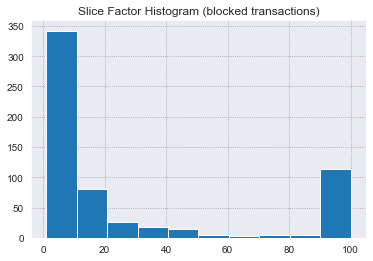

In [18]:
ax = swaps1_df[swaps1_df.status=='BLOCKED_BY_VOLATILITY_MITIGATION'].slice_factor.hist()

ax.set_title('Slice Factor Histogram (blocked transactions)')

Text(0.5, 1.0, 'Slice Factor Curve Histogram (blocked transactions)')

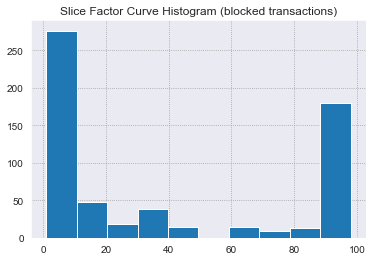

In [19]:
ax = swaps1_df[swaps1_df.status=='BLOCKED_BY_VOLATILITY_MITIGATION'].slice_factor_curve.hist()

ax.set_title('Slice Factor Curve Histogram (blocked transactions)')

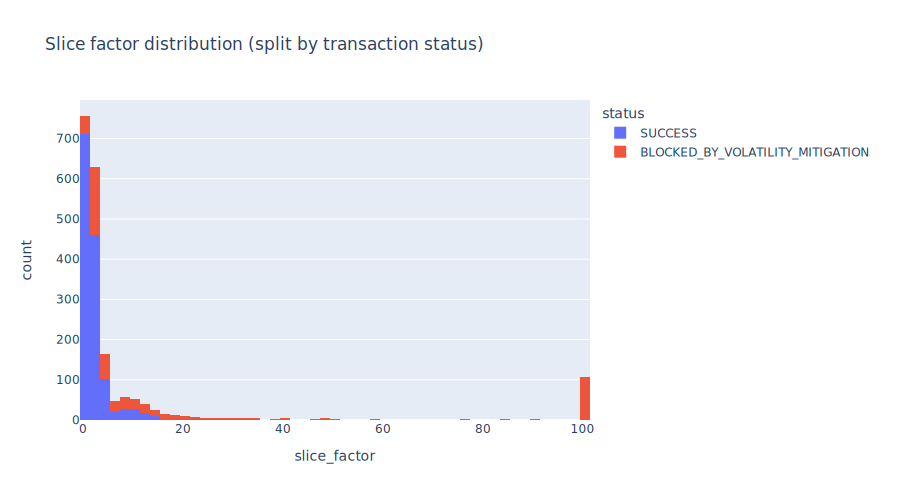

In [20]:
import plotly.express as px


fig = px.histogram(swaps1_df, x="slice_factor", color="status",
                  title='Slice factor distribution (split by transaction status)', width=900, height=500).update_xaxes(categoryorder='total descending')
fig.show()

Note: in the plot above are not included the transactions for which TWAP COUDN'T BE COMPUTED and which weren't checked therefore by volatility mitigation mechanism

It can be observed that there is a high number of blocked transactions, with a slice_factor near
zero, which is not typical for an usual pool. The reason for this strange pattern is described
below.

**The slice factor of the blocked transactions varies between 1 and 100**

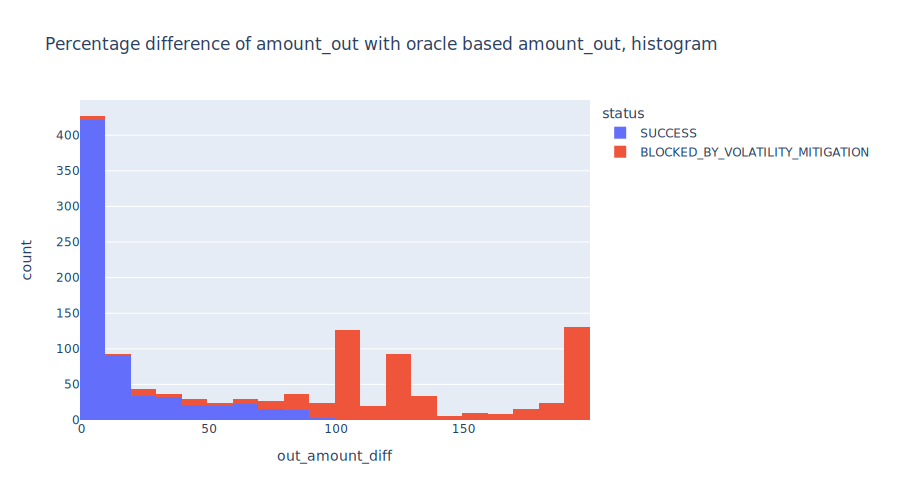

In [21]:
import plotly.express as px

fig = px.histogram(swaps1_df[swaps1_df.slice_factor > 1], x="out_amount_diff", color="status",
                  title='Percentage difference of amount_out with oracle based amount_out, histogram', width=900, height=500).update_xaxes(categoryorder='total descending')
fig.show()

**Most blocked transactions have a price difference with the one obtained from oracle by more than 100%**

Text(0.5, 1.0, 'Swaps slice_factor/out_amount_diff scatterplot (split by status)')

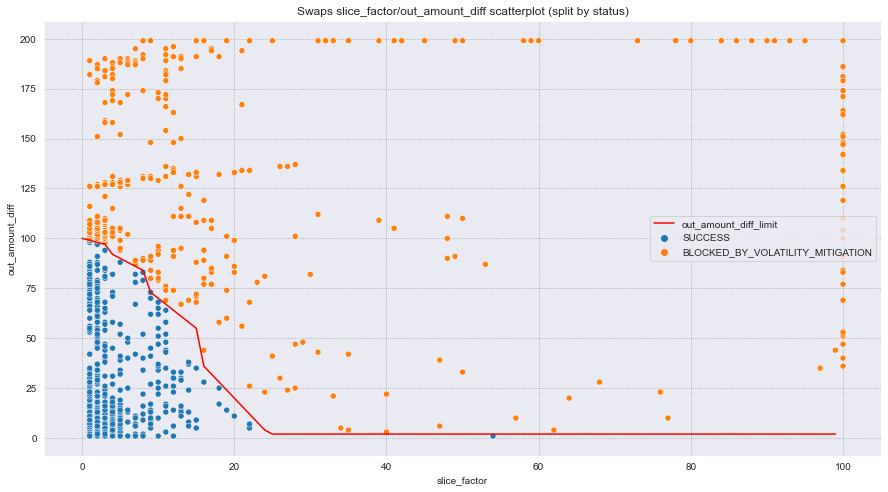

In [22]:
from scipy import stats

fig, ax = plt.subplots(figsize=(15, 8))
    
sns.scatterplot(data=swaps1_df[swaps1_df.mitigator_check_status == 'CHECKED'], x='slice_factor', y='out_amount_diff', hue='status')

slice_factor = np.arange(0, 100)
slice_factor_curve = slice_factor * np.sqrt(slice_factor).astype(int)
slice_factor_curve[slice_factor_curve > 98] = 98
out_amount_diff = (100 - slice_factor_curve)
sns.lineplot(x=slice_factor, y=out_amount_diff, color='red', label='out_amount_diff_limit')
ax.set_title('Swaps slice_factor/out_amount_diff scatterplot (split by status)')

The out_amount_diff_limit border is not smooth, because the slice_factor_curve is computed according to the formula slice_factor * sqrt(slice_factor), where the sqrt(slice_factor) is rounded down in the original contract

**The successful and blocked transactions are not clustered**

Text(0, 0.5, 'Count')

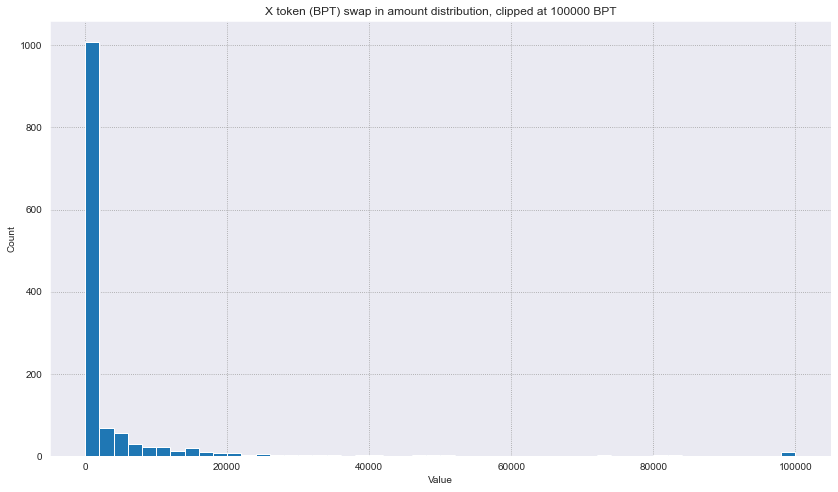

In [23]:
UPPER_LIMIT = 100000

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == X_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"X token ({X_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {X_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

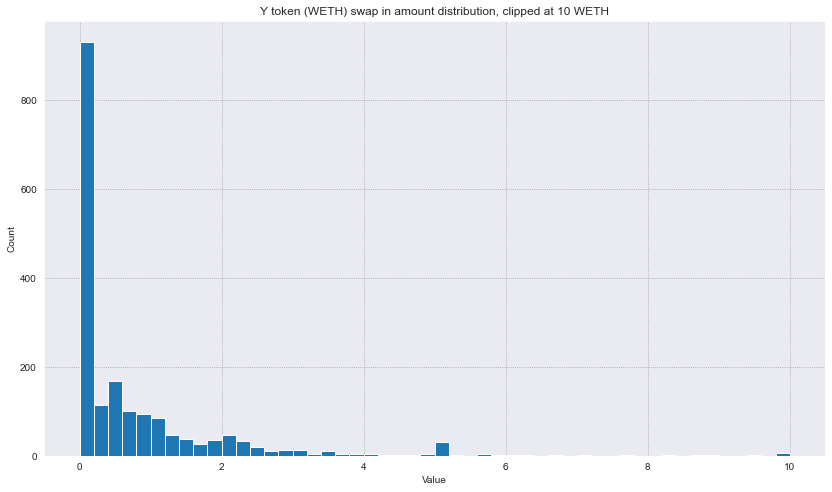

In [24]:
UPPER_LIMIT = 10

fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT

ax = amounts.hist(range=(0, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, clipped at {UPPER_LIMIT} {Y_NAME}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

Text(0, 0.5, 'Count')

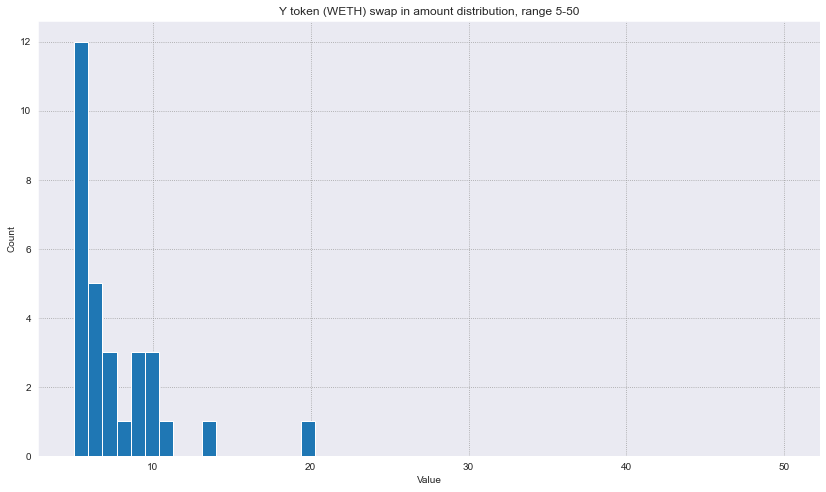

In [25]:
LOWER_LIMIT = 5
UPPER_LIMIT = 50
fig, ax = plt.subplots(figsize=(14, 8))

amounts = swaps0_df[swaps0_df.token_in == Y_NAME].token_in_amount.copy()
amounts[amounts > UPPER_LIMIT] = UPPER_LIMIT
amounts = amounts[amounts > LOWER_LIMIT]
ax = amounts.hist(range=(LOWER_LIMIT, UPPER_LIMIT), bins=50)

ax.set_title(f"Y token ({Y_NAME}) swap in amount distribution, range {LOWER_LIMIT}-{UPPER_LIMIT}")
ax.set_xlabel('Value')
ax.set_ylabel('Count')

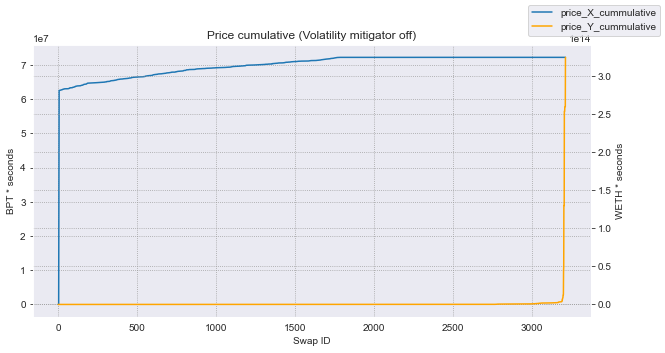

In [26]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.id, swaps0_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps1_df.id, swaps1_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator off)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

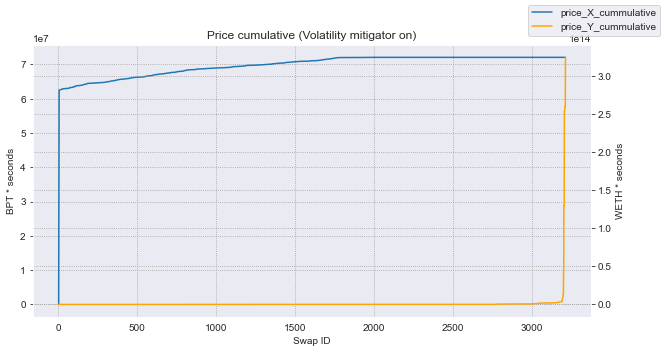

In [27]:

fig, ax = plt.subplots(figsize=(10, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.id, swaps1_df.price_X_cumulative,  label='price_X_cummulative')
ax2.plot(swaps1_df.id, swaps1_df.price_Y_cumulative,  label='price_Y_cummulative',  color='orange')

ax.set_title('Price cumulative (Volatility mitigator on)')
ax.set_xlabel('Swap ID')
ax.set_ylabel(X_NAME + ' * seconds') 
ax2.set_ylabel(Y_NAME + ' * seconds')

fig.legend()

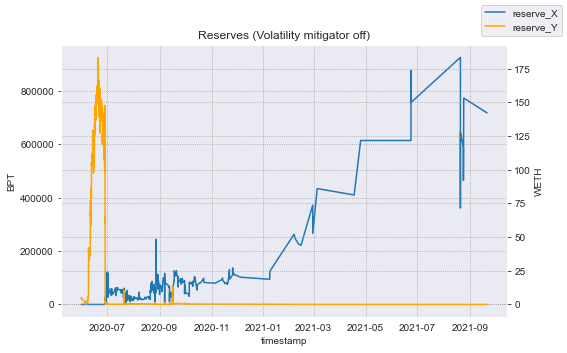

In [28]:
fig, ax = plt.subplots(figsize=(8, 5))

ax2 = ax.twinx()

ax.plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_X, label='reserve_X')
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator off)')

fig.legend()

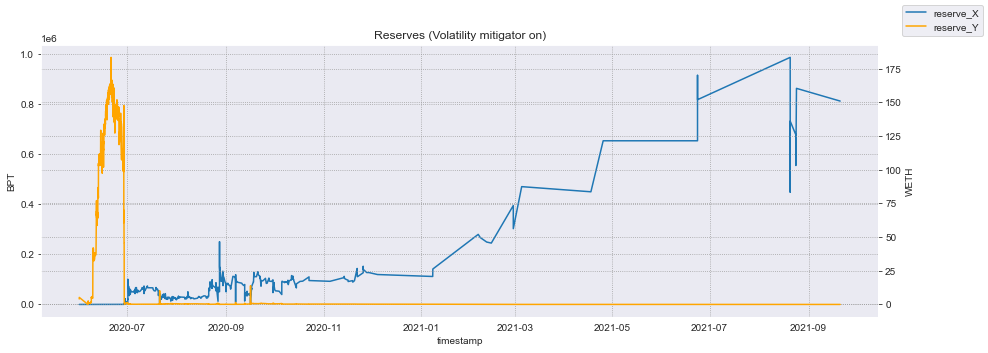

In [29]:
fig, ax = plt.subplots(figsize=(15, 5))

ax2 = ax.twinx()

ax.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_X, label='reserve_X')
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, label='reserve_Y', color='orange')

ax.set_xlabel('timestamp')
ax.set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax.set_title('Reserves (Volatility mitigator on)')

fig.legend()

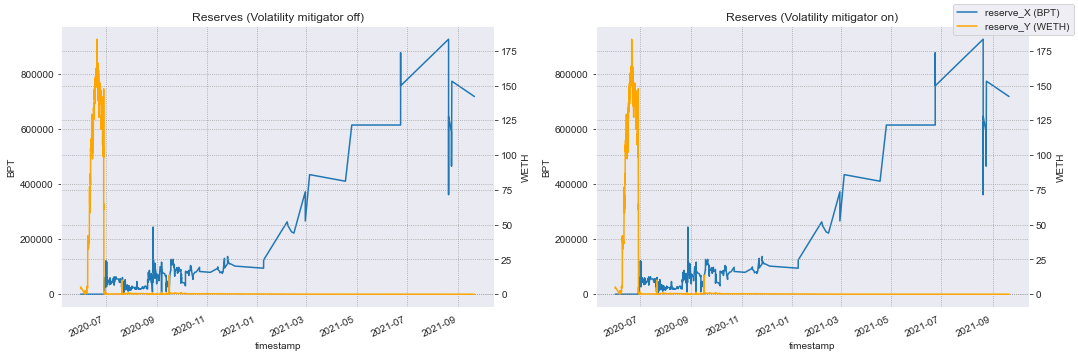

In [30]:

fig, ax = plt.subplots(1, 2,figsize=(15, 5))

ax2 = ax[0].twinx()

ax[0].plot(swaps0_df.transaction_timestamp, swaps0_df.reserve_X, label=f'reserve_X ({X_NAME})')
ax2.plot(swaps0_df.transaction_timestamp, swaps1_df.reserve_Y, label=f'reserve_Y ({Y_NAME})', color='orange')

ax[0].set_xlabel('timestamp')
ax[0].set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax[0].set_title('Reserves (Volatility mitigator off)')

ax2 = ax[1].twinx()


ax[1].plot(swaps1_df.transaction_timestamp, swaps0_df.reserve_X, )
ax2.plot(swaps1_df.transaction_timestamp, swaps1_df.reserve_Y, color='orange')

ax[1].set_xlabel('timestamp')
ax[1].set_ylabel(X_NAME)
ax2.set_ylabel(Y_NAME)
ax[1].set_title('Reserves (Volatility mitigator on)')

fig.autofmt_xdate(rotation=25)

fig.legend()
fig.tight_layout()

**On a high scale, the variation ov reserves looks similar**

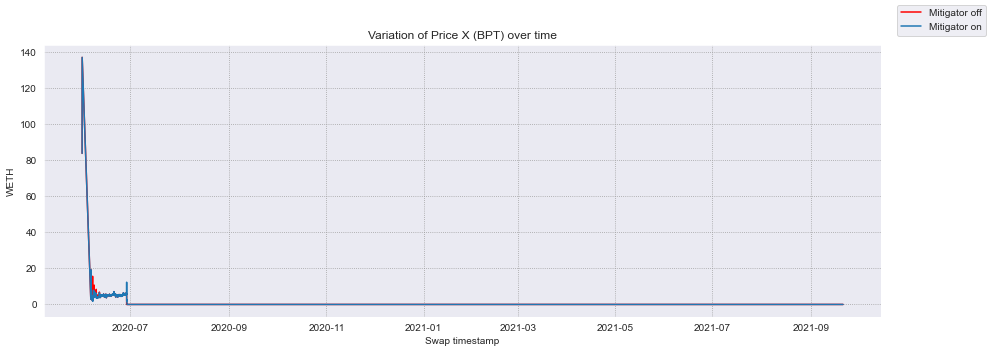

In [31]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=swaps0_df['transaction_timestamp'], y=swaps0_df['X_price'], linestyle='solid', marker=None, label='Mitigator off', color='red')
ax.plot_date(x=swaps1_df['transaction_timestamp'], y=swaps1_df['X_price'], linestyle='solid', marker=None, label='Mitigator on',)

ax.set_title(f'Variation of Price X ({X_NAME}) over time')
#ax.set_ylim(0, 0.1)
ax.set_xlabel('Swap timestamp')
ax.set_ylabel(Y_NAME)
fig.legend()

**It can be seen from the variation of price that the volatility mitigation mechanism changes the price variation visibly during only 1 time period.**

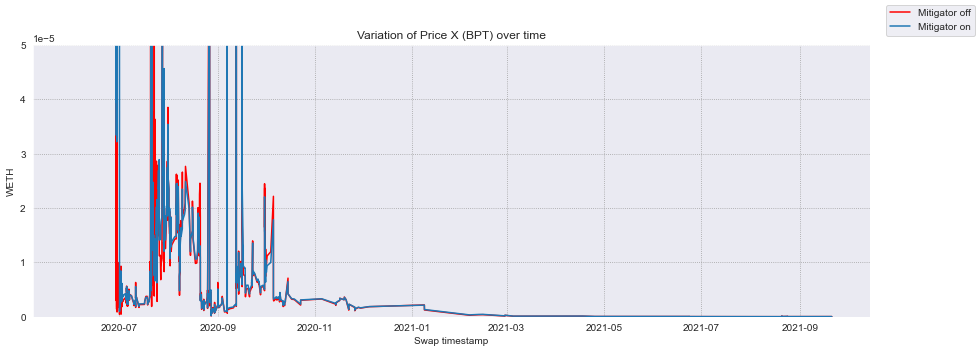

In [37]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(x=swaps0_df['transaction_timestamp'], y=swaps0_df['X_price'], linestyle='solid', marker=None, label='Mitigator off', color='red')
ax.plot_date(x=swaps1_df['transaction_timestamp'], y=swaps1_df['X_price'], linestyle='solid', marker=None, label='Mitigator on',)

ax.set_title(f'Variation of Price X ({X_NAME}) over time')
ax.set_ylim(0, 0.00005)
ax.set_xlabel('Swap timestamp')
ax.set_ylabel(Y_NAME)
fig.legend()

**By increasing the scale of y axis, the variations become more visible, but a significant decrease of price volatility with volatility mitigation mechanism turned on cannot be observed.**

## Count number of 1 hour periods with no swaps

Below, the distribution of the number of swaps per hour, for 3 stages of the same duration of the pool is computed 

- 1st stage - initial period 
- 2nd stage - middle period
- 3nd stage - last period

In [89]:
swaps1_df.transaction_timestamp.min()

Timestamp('2020-05-31 20:25:35')

In [90]:
sim1_indexed_df = swaps1_df.copy()
sim1_indexed_df.index = swaps1_df.transaction_timestamp
resampled = sim1_indexed_df.resample('1h').size()
resampled

transaction_timestamp
2020-05-31 20:00:00    3
2020-05-31 21:00:00    1
2020-05-31 22:00:00    0
2020-05-31 23:00:00    0
2020-06-01 00:00:00    0
                      ..
2021-09-20 15:00:00    0
2021-09-20 16:00:00    0
2021-09-20 17:00:00    0
2021-09-20 18:00:00    0
2021-09-20 19:00:00    1
Freq: H, Length: 11448, dtype: int64

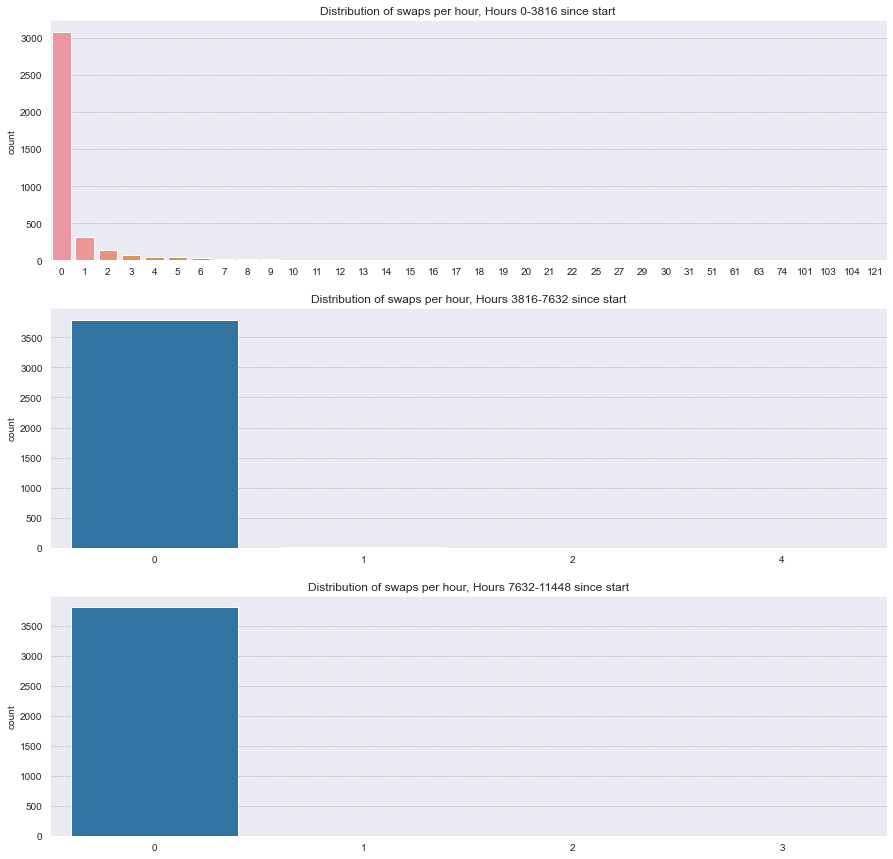

In [91]:
N_STAGES = 3

fig, ax = plt.subplots(N_STAGES, 1, figsize=(15, N_STAGES*5))
ax = ax.ravel()

n = len(resampled)

for i in range(0, N_STAGES):
    start_idx = i * (n // N_STAGES)
    end_idx = (i + 1) * (n // N_STAGES)
   # time_elapsed = (resampled.index[end_idx] - resampled.index[start_idx])
    
    sns.countplot(x=resampled.iloc[start_idx:end_idx], ax=ax[i])
    ax[i].set_title(f"Distribution of swaps per hour, Hours {start_idx}-{end_idx} since start")
   # ax.set_title('Swaps per hour distribution')

The count for x = 0 (no swaps per hour), shows how many missing periods for TWAP value exist. It can be seen that after the initial period, the transactions frequency fell almost to 0

By analyzing the data, it can be observed that in the second and third stage almost no swaps happened, indication the 'death' of the pool

## Count number of 24 hour periods with no swaps

In [39]:
sim1_indexed_df = swaps1_df.copy()
sim1_indexed_df.index = swaps1_df.transaction_timestamp
resampled24 = sim1_indexed_df.resample('24h').size()
resampled24.head()

transaction_timestamp
2020-05-31    4
2020-06-01    0
2020-06-02    0
2020-06-03    0
2020-06-04    0
Freq: 24H, dtype: int64

In [40]:
resampled24[resampled24 == 0].shape

(332,)

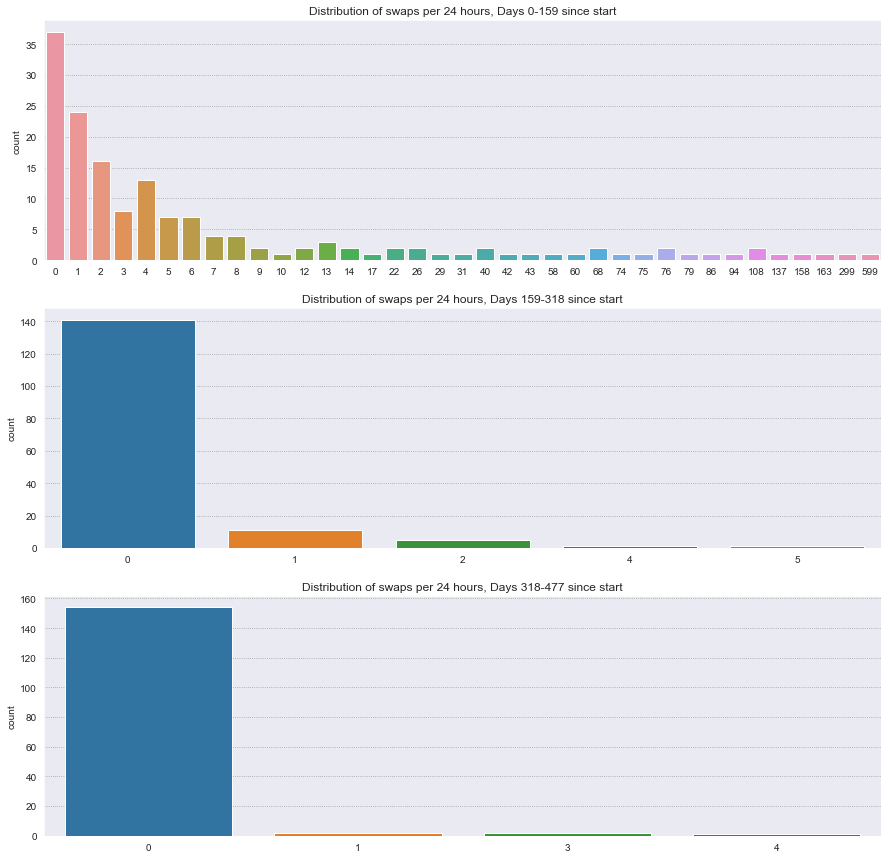

In [41]:
N_STAGES = 3

fig, ax = plt.subplots(N_STAGES, 1, figsize=(15, N_STAGES*5))
ax = ax.ravel()

n = len(resampled24)

for i in range(0, N_STAGES):
    start_idx = i * (n // N_STAGES)
    end_idx = (i + 1) * (n // N_STAGES)
    
    sns.countplot(x=resampled24.iloc[start_idx:end_idx], ax=ax[i])
    ax[i].set_title(f"Distribution of swaps per 24 hours, Days {start_idx}-{end_idx} since start")
   # ax.set_title('Swaps per hour distribution')

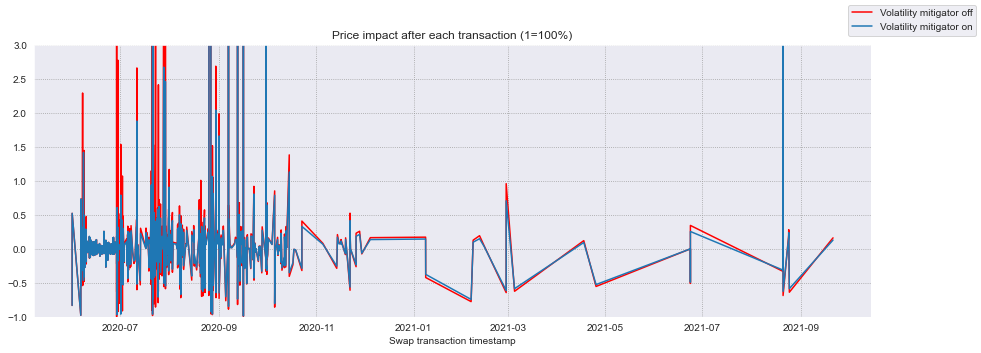

In [42]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot_date(data=swaps0_df, x='transaction_timestamp', y='price_diff', linestyle='solid', color='red', marker=None, label='Volatility mitigator off')
ax.plot_date(data=swaps1_df, x='transaction_timestamp', y='price_diff', linestyle='solid', marker=None, label='Volatility mitigator on')

ax.set_ylim(-1, 3)
ax.set_xlabel('Swap transaction timestamp')
ax.set_title('Price impact after each transaction (1=100%)')
fig.legend()

**The most transactions with a significant price impact are not blocked, for the majority of them there are no observations inside the oracle**

In [43]:
swaps1_df[swaps1_df.price_diff > 0.5]

,id,token_in,token_out,token_in_amount,token_out_amount_min,token_out_amount,system_fee,mitigator_check_status,oracle_amount_out,out_amount_diff,slice_factor,slice_factor_curve,status,block_number,block_timestamp,transaction_timestamp,txd,sender,to,transaction_id,reserve_X_before,reserve_Y_before,k_before,price_X_cumulative_before,price_Y_cumulative_before,is_volatility_mitigator_on_before,reserve_X,reserve_Y,k,price_X_cumulative,price_Y_cumulative,is_volatility_mitigator_on,X_price,price_diff
3,4,WETH,BPT,1.000000,0.0,0.008919,0.004000,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,223.0,2020-05-31 21:03:53,2020-05-31 21:03:51,0x712c35f27ffe151a02846fd3748ff034e6d123b45ca0...,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0x2593ca08fda3c2526409493cd1ffa3f656d0b7c6,4,0.047150,4.243520,0.200081,64965,9,True,0.038231,5.239520,0.200311,202666,26,True,1.370498e+02,0.522765
10,14,WETH,BPT,0.455837,0.0,0.061735,0.001823,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,32168.0,2020-06-06 10:10:08,2020-06-06 10:09:59,0x0623ed22feebc97ab07996b852fd528c3fe2be89f00e...,0x40a7cb7052c274cc2e568c324b4c5d94383bec4f,0x40a7cb7052c274cc2e568c324b4c5d94383bec4f,14,0.257163,1.428563,0.367374,62559520,6613,True,0.195428,1.882577,0.367909,62564853,6786,True,9.633086e+00,0.734103
11,15,WETH,BPT,0.457138,0.0,0.037875,0.001829,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,32194.0,2020-06-06 10:16:38,2020-06-06 10:16:32,0x005ef4d0c8ba27aa64a49e6a98181140776d2d9478d2...,0x40a7cb7052c274cc2e568c324b4c5d94383bec4f,0x40a7cb7052c274cc2e568c324b4c5d94383bec4f,15,0.195428,1.882577,0.367909,62564853,6786,True,0.157553,2.337886,0.368341,62568610,6826,True,1.483874e+01,0.540393
66,70,WETH,BPT,0.622761,0.0,0.121010,0.002491,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,41120.0,2020-06-07 23:28:08,2020-06-07 23:28:02,0x22f8f1d0413c31acb1f5435f3028b9e854189ad985d4...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0xdde961eebca0d3a7663d774c75fa30f5545cf8c3,70,0.339432,1.112842,0.377734,63070641,44687,True,0.218422,1.733112,0.378551,63102558,47656,True,7.934681e+00,1.420186
2061,2108,WETH,BPT,0.202547,0.0,517.982750,0.000810,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,162394.0,2020-06-29 00:46:38,2020-06-29 00:46:33,0xb116b8f7d74f4ebaa0888ee68ab90998a6b154cfc0d0...,0xf1ad4bfdf8829d55ec0ce7900ef9d122b2610673,0xf1ad4bfdf8829d55ec0ce7900ef9d122b2610673,2108,2460.529494,0.751997,1850.311770,72063388,1925242,True,1942.546744,0.953734,1852.672507,72063388,1925242,True,4.909708e-04,0.606453
2069,2116,WETH,BPT,0.127639,0.0,760.378052,0.000511,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,162414.0,2020-06-29 00:51:38,2020-06-29 00:51:32,0xd71f89dcc7d0e9c84d0f0ef2a9d8da222345c7404cb3...,0xf1ad4bfdf8829d55ec0ce7900ef9d122b2610673,0xf1ad4bfdf8829d55ec0ce7900ef9d122b2610673,2116,3749.466113,0.496739,1862.505444,72063388,2626293,True,2989.088062,0.623867,1864.794591,72063388,2626293,True,2.087150e-04,0.575415
2642,2694,WETH,BPT,0.036845,0.0,23478.916440,0.000147,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,175819.0,2020-07-01 08:42:53,2020-07-01 08:42:42,0x8170355e974aaf4125365ba0587a20a821c65949ec3a...,0x693c188e40f760ecf00d2946ef45260b84fbc43e,0x693c188e40f760ecf00d2946ef45260b84fbc43e,2694,93105.124873,0.108172,10071.331448,72063421,1844327182,True,69626.208432,0.144870,10086.723886,72063421,2128363729,True,2.080677e-06,0.790874
2721,2775,WETH,BPT,0.100000,0.0,30248.683500,0.000400,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,233977.0,2020-07-11 11:02:23,2020-07-11 11:02:09,0x57aa3467a36cac3690311d4e64e814721f53fcf470ee...,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,0x3f75275899d5d6188942d56a4da532ef2eb374b2,2775,73755.398857,0.142392,10502.164806,72063424,257836281559,True,43506.715357,0.241992,10528.268835,72063424,257836281559,True,5.562171e-06,1.881066
2738,2792,WETH,BPT,0.042476,0.0,12077.710203,0.000170,CANT_CONSULT_ORACLE,NaN,NaN,NaN,NaN,SUCCESS,285988.0,2020-07-20 11:45:08,2020-07-20 11:45:05,0x21c96c545e7039328ab41eef4166fde4f859ff474407...,0x9021c84f3900b610ab8625d26d739e3b7bff86ab,0x9021c84f

**! See how the changes influence the results in notebooks with suffix _mod1 and _mod2**